In [1]:
import os
import re
from typing import List

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from nltk import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC                         # Высокий шанс переобучения
from sklearn.neighbors import KNeighborsClassifier  # Плохо работает на данных большой размерности из-за проклятия размерности
from sklearn.naive_bayes import MultinomialNB       # Подразумевается, что признаки независимые, но для текста это неверно
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from nltk.corpus import stopwords
import pymorphy3

from catboost import CatBoostClassifier

import warnings 
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv("../data/lenta-ru-news_cleaned_small.csv")

In [3]:
df = df.dropna(axis=0, how='any')
correct = df["topic"].value_counts() > 200
df = df[df["topic"].isin(correct[correct].index)]
df.head()

,url,title,text,topic,tags,date,topic_num
0,https://lenta.ru/news/2016/01/12/nornikel/,Роскомнадзор разрешил «дочке» «Норникеля» оказ...,Компания «Единство» — дочернее подразделение «...,69-я параллель,Все,2016/01/12,14
1,https://lenta.ru/news/2016/02/03/arctic/,Российская компания анонсировала женский тур в...,Российским женщинам на 8 Марта предложили отпр...,69-я параллель,Все,2016/02/03,14
2,https://lenta.ru/news/2016/03/02/krasnoyarksno...,Красноярский край столкнулся с нехваткой снега,На севере Красноярского края к началу весны на...,69-я параллель,Все,2016/03/02,14
3,https://lenta.ru/news/2016/03/02/migrantsfinland/,Беженцы в Мурманской области потребовали выпус...,Беженцы из стран Ближнего Востока и Африки во ...,69-я параллель,Все,2016/03/02,14
4,https://lenta.ru/news/2016/03/04/universityout/,Мурманский вуз лишился государственной аккреди...,Мурманский государственный технический универс...,69-я параллель,Все,2016/03/04,14


In [4]:
df[df.isna().any(axis=1)]

,url,title,text,topic,tags,date,topic_num


In [5]:
topic = df.topic.drop_duplicates().values
category = dict()
for i in range(len(topic)):
    category[topic[i]] = i 

<Axes: xlabel='topic', ylabel='count'>

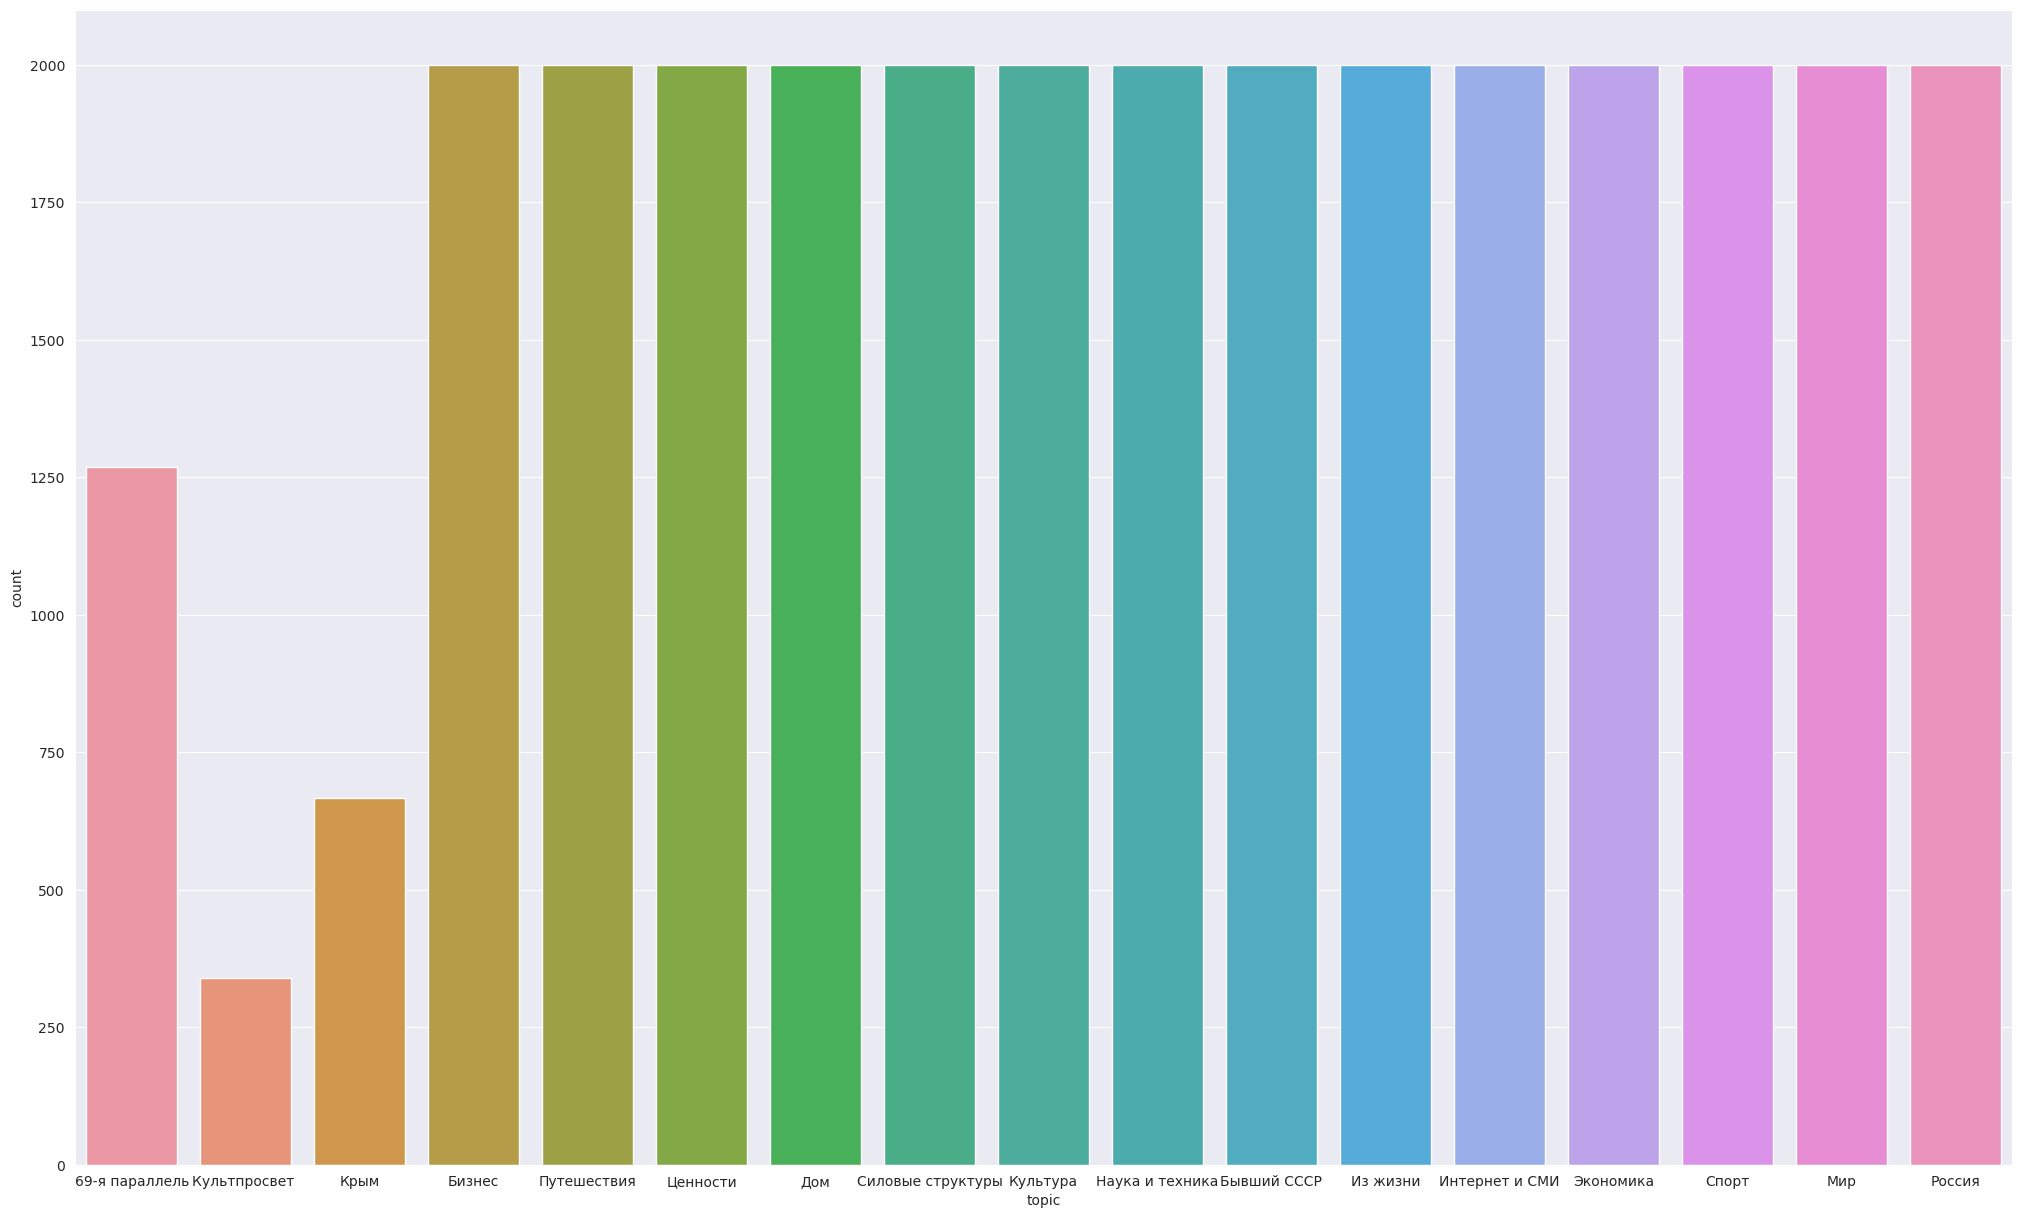

In [6]:
plt.figure(figsize=(25, 15))
sns.countplot(x=df.topic)

In [7]:
stop_words = set(stopwords.words('russian'))

def preprocess_text(text: str) -> List[str]:
    return re.sub(r"[^\w\s]+", '', text).lower().split()

def preprocess_porter_stem(text: str) -> str:
    prep_text = preprocess_text(text)
    stemmer = PorterStemmer()
    singles = [stemmer.stem(x) for x in prep_text if x not in stop_words]
    return ' '.join(singles)

def preprocess_snowball_stem(text: str) -> str:
    prep_text = preprocess_text(text)
    stemmer = SnowballStemmer("russian")
    singles = [stemmer.stem(x) for x in prep_text if x not in stop_words]
    return ' '.join(singles)

def preprocess_wordnet_lem(text: str) -> str:
    prep_text = preprocess_text(text)
    lemmatizer = WordNetLemmatizer()
    singles = [lemmatizer.lemmatize(x) for x in prep_text if x not in stop_words]
    return ' '.join(singles)

def preprocess_pymrophy(text: str) -> str:
    prep_text = preprocess_text(text)
    morph = pymorphy3.MorphAnalyzer()
    singles = [morph.parse(x)[0].normal_form for x in prep_text if x not in stop_words]
    return ' '.join(singles)

In [8]:
df['topic_num'] = df['topic'].map(lambda x: category[x])
df['porter'] = df['text'].map(lambda x: preprocess_porter_stem(x))
df['snowball'] = df['text'].map(lambda x: preprocess_snowball_stem(x))
df['wordnet'] = df['text'].map(lambda x: preprocess_wordnet_lem(x))
df['pymorphy'] = df['text'].map(lambda x: preprocess_pymrophy(x))

In [9]:
train, test = train_test_split(df, test_size=0.3, stratify=df['topic_num'], shuffle=True, random_state=57)

In [10]:
test, val = train_test_split(test, test_size=0.5, random_state=52)

In [11]:
params = {
    'max_depth': [5, 20, 50, 100],
    'min_samples_split': [5, 10, 30, 50, 100],
    'min_samples_leaf': [5, 10, 30, 50, 100],
}
dec_tree_param = {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 100}

In [12]:
# tfidf = TfidfVectorizer(preprocessor=preprocess_snowball_stem)
# 
# x_val = tfidf.fit_transform(val['text'])
# y_val = val['topic_num']
# 
# grid_s = GridSearchCV(DecisionTreeClassifier(random_state=57), params, cv=5)
# grid_s.fit(x_val, y_val)
# dec_tree_param = grid_s.best_params_
# dec_tree_param

In [13]:
params_rt = {'n_estimators': [100, 300, 500],
             'max_depth': [50, 100, 200, 250],
             'min_samples_split': [25, 100, 200],
             'min_samples_leaf': [10, 30, 100]}

random_forest_param = {'n_estimators': 300,
 'min_samples_split': 25,
 'min_samples_leaf': 10,
 'max_depth': 100}

In [14]:
# tfidf = TfidfVectorizer(preprocessor=preprocess_snowball_stem)
# 
# x_val = tfidf.fit_transform(val['text'])
# y_val = val['topic_num']
# 
# grid_s_rt = RandomizedSearchCV(RandomForestClassifier(random_state=57), params_rt, cv=5)
# grid_s_rt.fit(x_val, y_val)
# random_forest_param = grid_s_rt.best_params_
# random_forest_param

In [15]:
sample = df.sample(df.shape[0] // 10)
train_smaller, test_smaller = train_test_split(sample, test_size=0.3, stratify=sample['topic_num'], shuffle=True, random_state=57)

tfidf = TfidfVectorizer(preprocessor=preprocess_snowball_stem)

x_news_train = tfidf.fit_transform(train_smaller['text'])
x_news_test = tfidf.transform(test_smaller['text'])

y_train = train_smaller['topic_num']
y_test = test_smaller['topic_num']

model = LogisticRegression(max_iter=300)
model_score = cross_val_score(model, x_news_train, y_train, cv=5, scoring=make_scorer(f1_score, average='macro'))
model_score

array([0.66874828, 0.66262352, 0.66482303, 0.68042019, 0.67754366])

In [16]:
from scipy.stats import mannwhitneyu

def find_best_model(x_train_df: pd.DataFrame, y_train_df: pd.DataFrame, x_test_df: pd.DataFrame, to_pipeline: List):
    best_score = None
    best_model = None
    for item in to_pipeline:
        prep = item[1][1]
        m = item[2][1]
        x_news_train = prep.fit_transform(x_train_df[item[0][0]])
        x_news_test = prep.transform(x_test_df[item[0][0]])
        score = cross_val_score(m, x_news_train, y_train_df, cv=10, scoring=make_scorer(f1_score, average='macro'))
        if best_score is None:
            best_score = score
            best_model = item
            print(f"Best model: {best_model[0][0]}-{best_model[1][0]}-{best_model[2][0]}")
        else:
            p = mannwhitneyu(np.array(best_score), np.array(score), alternative='less').pvalue
            if p < 0.05:
                best_score = score
                best_model = item
                print(f"Best model: {best_model[0][0]}-{best_model[1][0]}-{best_model[2][0]}")
    return best_model, best_score

In [17]:
def train_and_test_model(x_train_df: pd.DataFrame, y_train_df: pd.DataFrame, x_test_df: pd.DataFrame, y_test_df: pd.DataFrame, to_pipeline: List):
    for item in to_pipeline:
        pipe = Pipeline(item[1:])
        x_train_now = x_train_df[item[0][0]]
        x_test_now = x_test_df[item[0][0]]
        pipe.fit(x_train_now, y_train_df)
        print(f"{item[0][0]}+{item[1][0]}+{item[2][0]}")
        y_pred = pipe.predict(x_train_now)
        print(f"Train: {f1_score(y_train_df, y_pred, average='macro')}")
        y_pred = pipe.predict(x_test_now)
        print(f"Test: {f1_score(y_test_df, y_pred, average='macro')}")
        df = pd.DataFrame(data=classification_report(y_test_df, y_pred, output_dict=True))
        df.rename(mapper= lambda x: topic[int(x)] if x not in ['accuracy', 'macro avg', 'weighted avg'] else x, axis='columns', inplace=True)
        print(df)
        conf_m = confusion_matrix(y_test_df, y_pred)
        cm_display = sns.heatmap(conf_m, cmap="afmhot", xticklabels=topic, yticklabels=topic)
        cm_display.plot()
        plt.rcParams['xtick.major.pad']= 10
        plt.rcParams['ytick.major.pad']= 10
        plt.xticks(rotation=90)
        plt.show()
        

In [18]:
preprocess = [('porter', preprocess_porter_stem), ('snowball', preprocess_snowball_stem), ('wordnet', preprocess_wordnet_lem), ('pymorphy', preprocess_pymrophy)]
vectorizers = [('bow', CountVectorizer()), ('tfidf', TfidfVectorizer())]

In [19]:
all_log_reg = []

for p in preprocess:
    for v in vectorizers:
        all_log_reg.append([p, v, ('logreg', LogisticRegression(max_iter=300))])

log_reg_model, log_reg_score = find_best_model(train, train['topic_num'], test, all_log_reg)
print(log_reg_score)
print(log_reg_model)

Best model: porter-bow-logreg
[0.84898245 0.8646978  0.86126199 0.86614979 0.87159774 0.84349438
 0.84665059 0.85651974 0.86088903 0.86718125]
[('porter', <function preprocess_porter_stem at 0x70b4daabd620>), ('bow', CountVectorizer()), ('logreg', LogisticRegression(max_iter=300))]


In [20]:
all_dec_tree = []

for p in preprocess:
    for v in vectorizers:
        all_dec_tree.append([p, v, ('dectree', DecisionTreeClassifier(**dec_tree_param))])

dec_tree_model, dec_tree_score = find_best_model(train, train['topic_num'], test, all_dec_tree)
print(dec_tree_score)
print(dec_tree_model)

Best model: porter-bow-dectree
Best model: snowball-bow-dectree
[0.59601605 0.59727223 0.56586489 0.5819089  0.60300571 0.59794863
 0.61723765 0.59683723 0.58406467 0.60081376]
[('snowball', <function preprocess_snowball_stem at 0x70b4dc754680>), ('bow', CountVectorizer()), ('dectree', DecisionTreeClassifier(max_depth=100, min_samples_leaf=10,
                       min_samples_split=100))]


In [21]:
all_rand_forest = []

for p in preprocess:
    for v in vectorizers:
        all_rand_forest.append([p, v, ('rf', RandomForestClassifier(**random_forest_param))])

rand_forest_model, rand_forest_score = find_best_model(train, train['topic_num'], test, all_rand_forest)
print(rand_forest_score)
print(rand_forest_model)

Best model: porter-bow-rf
Best model: snowball-tfidf-rf
[0.72564749 0.72219251 0.73090025 0.72300579 0.73581354 0.71961745
 0.72128957 0.73342107 0.73000656 0.72488487]
[('snowball', <function preprocess_snowball_stem at 0x70b4dc754680>), ('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier(max_depth=100, min_samples_leaf=10, min_samples_split=25,
                       n_estimators=300))]


porter+bow+logreg
Train: 1.0
Test: 0.8753295170801715
           69-я параллель  Культпросвет         Крым      Бизнес  Путешествия  \
precision        0.923913       0.833333    0.941176    0.847518     0.906250   
recall           0.913978       0.775862    0.842105    0.812925     0.912587   
f1-score         0.918919       0.803571    0.888889    0.829861     0.909408   
support        186.000000      58.000000  114.000000  294.000000   286.000000   

             Ценности         Дом  Силовые структуры    Культура  \
precision    0.945017    0.931741           0.860841    0.894231   
recall       0.907591    0.919192           0.875000    0.908795   
f1-score     0.925926    0.925424           0.867863    0.901454   
support    303.000000  297.000000         304.000000  307.000000   

           Наука и техника  Бывший СССР    Из жизни  Интернет и СМИ  \
precision         0.916944     0.885246    0.840125        0.888889   
recall            0.941980     0.870968    0.896321      

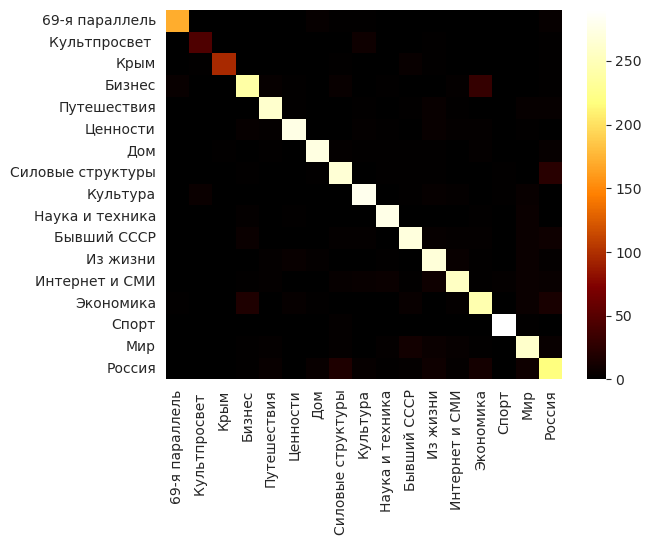

In [22]:
train_and_test_model(train, train['topic_num'], test, test['topic_num'], [log_reg_model])

snowball+bow+dectree
Train: 0.6651533775084321
Test: 0.5985657997685346
           69-я параллель  Культпросвет         Крым      Бизнес  Путешествия  \
precision        0.764286       0.593750    0.707547    0.485149     0.706522   
recall           0.575269       0.327586    0.657895    0.500000     0.681818   
f1-score         0.656442       0.422222    0.681818    0.492462     0.693950   
support        186.000000      58.000000  114.000000  294.000000   286.000000   

             Ценности         Дом  Силовые структуры    Культура  \
precision    0.595016    0.732877           0.617647    0.676976   
recall       0.630363    0.720539           0.621711    0.641694   
f1-score     0.612179    0.726655           0.619672    0.658863   
support    303.000000  297.000000         304.000000  307.000000   

           Наука и техника  Бывший СССР    Из жизни  Интернет и СМИ  \
precision         0.641694     0.645892    0.485714        0.572993   
recall            0.672355     0.735484

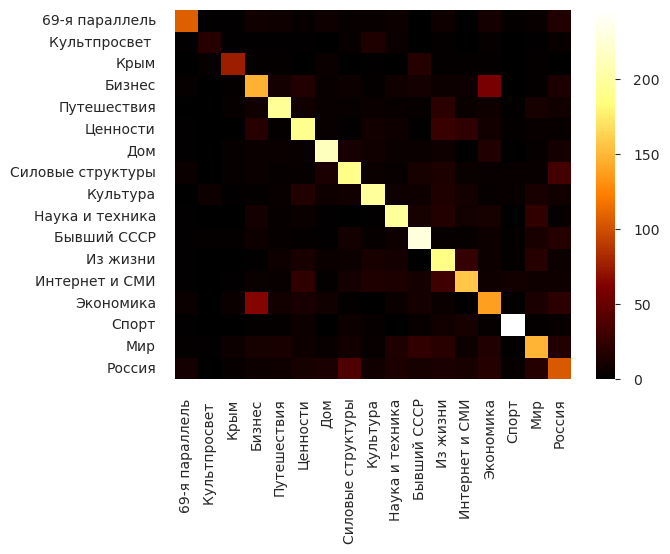

In [23]:
train_and_test_model(train, train['topic_num'], test, test['topic_num'], [dec_tree_model])

snowball+tfidf+rf
Train: 0.7945077444688258
Test: 0.7451929973602724
           69-я параллель  Культпросвет         Крым      Бизнес  Путешествия  \
precision        0.938272       0.941176    0.954545    0.687285     0.828947   
recall           0.817204       0.275862    0.552632    0.680272     0.881119   
f1-score         0.873563       0.426667    0.700000    0.683761     0.854237   
support        186.000000      58.000000  114.000000  294.000000   286.000000   

             Ценности         Дом  Силовые структуры    Культура  \
precision    0.815625    0.844068           0.639535    0.771429   
recall       0.861386    0.838384           0.904605    0.879479   
f1-score     0.837881    0.841216           0.749319    0.821918   
support    303.000000  297.000000         304.000000  307.000000   

           Наука и техника  Бывший СССР    Из жизни  Интернет и СМИ  \
precision         0.783282     0.697368    0.725989        0.797521   
recall            0.863481     0.854839   

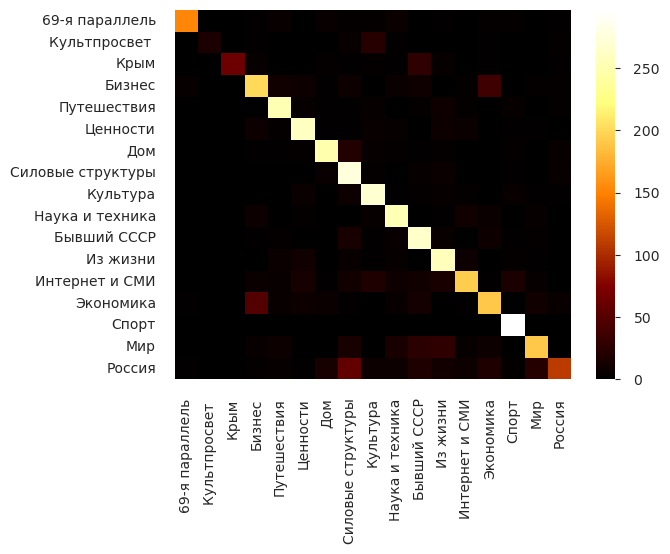

In [24]:
train_and_test_model(train, train['topic_num'], test, test['topic_num'], [rand_forest_model])

porter+bow+cb
Train: 0.8384515627027301
Test: 0.8027784011481581
           69-я параллель  Культпросвет         Крым      Бизнес  Путешествия  \
precision        0.915730       0.847826    0.841584    0.760274     0.882353   
recall           0.876344       0.672414    0.745614    0.755102     0.839161   
f1-score         0.895604       0.750000    0.790698    0.757679     0.860215   
support        186.000000      58.000000  114.000000  294.000000   286.000000   

             Ценности         Дом  Силовые структуры    Культура  \
precision    0.856643    0.866894           0.771605    0.840909   
recall       0.808581    0.855219           0.822368    0.843648   
f1-score     0.831919    0.861017           0.796178    0.842276   
support    303.000000  297.000000         304.000000  307.000000   

           Наука и техника  Бывший СССР    Из жизни  Интернет и СМИ  \
precision         0.871080     0.782991    0.730556        0.775362   
recall            0.853242     0.861290    0.8

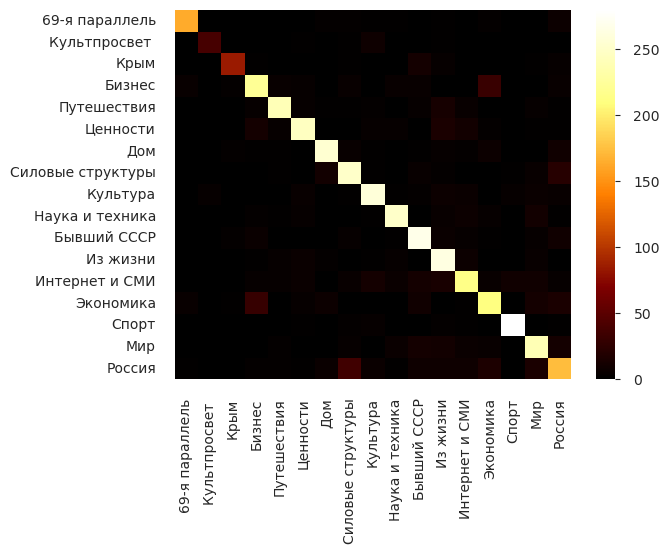

In [25]:
catboost_arr = [('porter', preprocess_porter_stem), ('bow', CountVectorizer()), ('cb', CatBoostClassifier(verbose=False, iterations=500))]

train_and_test_model(train, train['topic_num'], test, test['topic_num'], [catboost_arr])